# Imports and Read-ins

In [152]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import datetime as dt
import re

In [153]:
members = pd.read_csv('data/NSS_GreatCare_Members.csv')
admissions = pd.read_csv('data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('data/NSS_PrimaryCare_Office_Visits.csv')

C:\Users\jrior\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,5,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Getting the House in Order

### Convert date columns to datetime dtype, NPI columns to categories

In [154]:
members['Patient Date of Birth'] = pd.to_datetime(members['Patient Date of Birth'], format='%Y-%m-%d')
members['Period Start Date'] = pd.to_datetime(members['Period Start Date'], format='%Y-%m-%d')
members['Period End Date'] = pd.to_datetime(members['Period End Date'], format='%Y-%m-%d')
members['Empirically Attributed PCP Individual Provider NPI'] = (members['Empirically Attributed PCP Individual Provider NPI']
                                                                .astype("string")
                                                                .str.replace(".0","")
                                                                .astype("category"))
members['Empirically Attributed PCP Group Provider NPI'] = (members['Empirically Attributed PCP Group Provider NPI']
                                                                .astype("string")
                                                                .str.replace(".0","")
                                                                .astype("category"))

<ipython-input-154-a273ac2ff939>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  members['Empirically Attributed PCP Individual Provider NPI'] = (members['Empirically Attributed PCP Individual Provider NPI']
<ipython-input-154-a273ac2ff939>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  members['Empirically Attributed PCP Group Provider NPI'] = (members['Empirically Attributed PCP Group Provider NPI']


In [155]:
admissions['Encounter Start Date'] = pd.to_datetime(admissions['Encounter Start Date'], format='%Y-%m-%d')
admissions['Encounter End Date'] = pd.to_datetime(admissions['Encounter End Date'], format='%Y-%m-%d')
admissions['Facility Provider NPI'] = admissions['Facility Provider NPI'].astype("string").str.replace(".0","").astype("category")
admissions['Attending Provider NPI'] = admissions['Attending Provider NPI'].astype("string").str.replace(".0","").astype("category")

<ipython-input-155-83567c4d68b9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  admissions['Facility Provider NPI'] = admissions['Facility Provider NPI'].astype("string").str.replace(".0","").astype("category")
<ipython-input-155-83567c4d68b9>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  admissions['Attending Provider NPI'] = admissions['Attending Provider NPI'].astype("string").str.replace(".0","").astype("category")


In [156]:
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')
pcp['Service Provider NPI'] = pcp['Service Provider NPI'].astype("string").str.replace(".0","").astype("category")
pcp['Provider Group NPI'] = pcp['Provider Group NPI'].astype("string").str.replace(".0","").astype("category")

<ipython-input-156-521b44910019>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Service Provider NPI'] = pcp['Service Provider NPI'].astype("string").str.replace(".0","").astype("category")
<ipython-input-156-521b44910019>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Provider Group NPI'] = pcp['Provider Group NPI'].astype("string").str.replace(".0","").astype("category")


### Take select columns from the dataframes

In [157]:
memb = members[['Patient ID', 'Primary Plan ID', 'Patient Age Integer', 'Patient Date of Birth', 'Patient ZIP Code 5-Digit',
       'Empirically Attributed PCP Individual Provider NPI',
       'Empirically Attributed PCP Individual Provider Description',
       'Empirically Attributed PCP Group Provider NPI',
       'Empirically Attributed PCP Group Provider Description']]

In [158]:
adm = admissions[['Encounter ID', 'Patient ID', 'Attending Provider NPI',
       'Facility Provider NPI', 'Encounter Start Date', 'Encounter End Date',
       'Principal Discharge Diagnosis ICD-9-CM Code',
       'Principal Discharge Diagnosis ICD-9-CM Description',
       'Principal Discharge Diagnosis ICD-10-CM Code',
       'Principal Discharge Diagnosis ICD-10-CM Description',
       'Primary Plan Allowed Amount', 'Primary Plan Paid Amount',
       'Patient Paid Amount']]

In [159]:
#reduce pcp to relevant columns
pc = pcp[['Encounter ID','Patient ID', 'Attending Provider NPI', 'Service Provider NPI',
          'Provider Group NPI','Encounter Date']]                                                                     

# Problem 1: 30-day Readmission Rate

## Preparation: create Patient Adm Count

In [160]:
#count how many visits each patient has had up to and including current visit
adm['Patient Adm Count'] = adm.groupby('Patient ID')['Encounter Start Date'].transform('rank', method = 'first')

<ipython-input-160-e07c32f388a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm['Patient Adm Count'] = adm.groupby('Patient ID')['Encounter Start Date'].transform('rank', method = 'first')


## Self-join on Patient ID and Patient Adm Count

In [161]:
#Create new dataframe from admissions that only has three columns
readmits = adm[['Patient ID', 'Patient Adm Count', 'Encounter Start Date']]

#Add 1 to all patient_adm_ct. This transformation allows us to put the discharge date from the patient's previous hospital
#visit on the same line as their current visit, thus allowing us to calculate a difference in dates.
readmits['Patient Adm Count'] -= 1

#merge the two dataframes on patient id and the transformed patient_adm_ct
readmissions = pd.merge(adm, readmits, how = 'left', on = ['Patient ID', 'Patient Adm Count'], suffixes = ('', ' Next'))

#calculate the days of difference between next encounter's start date and the current encounter's end date
readmissions['Days Until Readmission'] = readmissions['Encounter Start Date Next'] - readmissions['Encounter End Date']

#create boolean 'Under 30 Days'
readmissions['Under 30 Days'] = (readmissions['Days Until Readmission'] >= dt.timedelta(days = 0)) & (readmissions['Days Until Readmission'] <= dt.timedelta(days = 30))

#Get 30-day readmission rate
#First pass at under-30-day rate.
under_30_d_rate = sum(readmissions['Under 30 Days'])/len(readmissions.index)
print(round(under_30_d_rate*100,2), '% readmitted under 30 days')

11.27 % readmitted under 30 days


<ipython-input-161-7ceb3e4dc286>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readmits['Patient Adm Count'] -= 1


In [162]:
#checking my work
readmissions[readmissions['Patient Adm Count']>= 2].count()
readmissions['Patient Adm Count'].unique()
readmissions.groupby(['Patient ID', 'Patient Adm Count']).ngroups

6213

### Mean days between release and readmission

In [163]:
#mean readmission time
readmissions['Days Until Readmission'].mean()

Timedelta('104 days 20:28:34.285714286')

### 30-day readmission rates by month

    Encounter Month  Encounters Count  Under 30 Days Count  Under 30 Days Rate
0        2009-11-30                 2                    0            0.000000
1        2009-12-31                26                    6           23.076923
2        2010-01-31                45                    2            4.444444
3        2010-02-28                30                    0            0.000000
4        2010-03-31                31                    3            9.677419
..              ...               ...                  ...                 ...
110      2019-01-31                 1                    0            0.000000
111      2019-02-28                 4                    0            0.000000
112      2019-03-31                 0                    0                 NaN
113      2019-04-30                 1                    0            0.000000
114      2019-05-31                 1                    0            0.000000

[115 rows x 4 columns]


[(14244.0, 18220.45)]

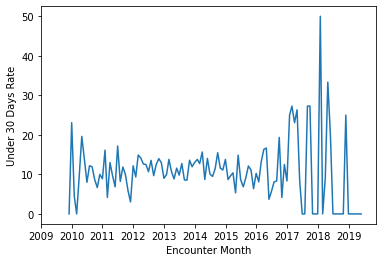

In [164]:
monthly_u30 = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Under 30 Days'].sum()
monthly_u30 = pd.DataFrame({'Encounter Month':monthly_u30.index, 'Under 30 Days Count':monthly_u30.values})


monthly_encounters = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Encounter ID'].count()
monthly_encounters = pd.DataFrame({'Encounter Month': monthly_encounters.index, 'Encounters Count': monthly_encounters.values})

monthly_u30_rates = pd.merge(monthly_encounters, monthly_u30, how = 'inner')

monthly_u30_rates['Under 30 Days Rate'] = 100*monthly_u30_rates['Under 30 Days Count'] / monthly_u30_rates['Encounters Count']

print(monthly_u30_rates)

g = sns.lineplot(x = 'Encounter Month', y = 'Under 30 Days Rate', data = monthly_u30_rates)
g.set(xlim = (pd.to_datetime('2008-12-31'),None))

In [165]:
#Investigative: looks like there's one Encounter for 1996, and everything else is 2009 and later.
readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='Y'))['Encounter ID'].count()

Encounter End Date
2009-12-31      28
2010-12-31     422
2011-12-31     806
2012-12-31    1160
2013-12-31    1208
2014-12-31    1234
2015-12-31     793
2016-12-31     366
2017-12-31     139
2018-12-31      50
2019-12-31       7
Freq: A-DEC, Name: Encounter ID, dtype: int64

# Problem 2: 7-day PCP Rate

## Merge readmissions and pcp, then clean until at most 1 pcp visit per hospital visit

In [166]:
#merger readmissions with pc
readm_pcp = pd.merge(readmissions, pc, how = 'left', on = 'Patient ID', suffixes = ('', ' PCP'))

#create timedelta column between hospital release and PCP visit (will have negatives)
readm_pcp['Hospital to PCP Days'] = readm_pcp['Encounter Date'] - readm_pcp['Encounter End Date']

#cut out all rows with negative time in Hospital to PCP Days, but keep na rows (people who never saw PCP)
readm_pcp = readm_pcp[(readm_pcp['Hospital to PCP Days'] >= dt.timedelta(days = 0)) | (readm_pcp['Hospital to PCP Days'].isnull())]

#Keep people who never saw PCP and rows where Hospital to PCP Days is minimized by Patient ID and patient_adm_ct
readm_pcp = readm_pcp[readm_pcp['Hospital to PCP Days'].isnull() 
                      | 
                      (readm_pcp['Hospital to PCP Days'] == readm_pcp.groupby(['Patient ID', 'Patient Adm Count'])['Hospital to PCP Days'].transform('min'))]

#create boolean column for PCP visits within 7 days
readm_pcp['PCP Under 7 Days'] = readm_pcp['Hospital to PCP Days'] <= dt.timedelta(days = 7)

# merge to new re_pcp dataframe, fill NAs with False
re_pcp = pd.merge(readmissions, readm_pcp, how = 'left')
re_pcp['PCP Under 7 Days'] = re_pcp['PCP Under 7 Days'].fillna(False)

re_pcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,...,Encounter Start Date Next,Days Until Readmission,Under 30 Days,Encounter ID PCP,Attending Provider NPI PCP,Service Provider NPI,Provider Group NPI,Encounter Date,Hospital to PCP Days,PCP Under 7 Days
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,14171523,168389,2013-01-12,2013-01-14,NaN,NaN,O70.0,First degree perineal laceration during delivery,...,NaT,NaT,False,COV|PCSL|DS1|10033|P|711310|1043427248|1,NaN,161996,43427248,2014-02-16,398 days,False
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,123315,2014-01-05,2014-01-12,348.4,Compression of brain,NaN,NaN,...,NaT,NaT,False,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,NaN,1619199791,43427248,2014-01-12,0 days,True
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,178511,123315,2012-06-13,2012-06-21,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,...,NaT,NaT,False,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,NaN,16593921,43427248,2012-06-27,6 days,True
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1087,14255839,2012-12-06,2012-12-09,NaN,NaN,O70.1,Second degree perineal laceration during delivery,...,NaT,NaT,False,COV|PCSL|DS1|10101|P|1189971|1043427248|1,NaN,19525383,43427248,2012-12-12,3 days,True
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,151458,1992818256,2015-03-11,2015-03-14,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",...,NaT,NaT,False,COV|PCSL|DS1|10118|P|486026|1043427248|1,NaN,1316361942,43427248,2015-11-04,235 days,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,17043417,1689772592,2015-02-06,2015-02-11,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",...,NaT,NaT,False,COV|PCSL|DS1|9979|P|281365|1477666352|1,NaN,17277995,1477666352,2015-02-15,4 days,True
6210,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,14255839,2014-08-07,2014-08-10,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,...,NaT,NaT,False,COV|PCSL|DS1|9981|P|1094367|1043427248|1,NaN,1992932388,43427248,2014-08-11,1 days,True
6211,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,168981,2015-11-21,2015-11-23,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,...,2015-11-24,1 days,True,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1487734547,158787,2015-12-05,12 days,False
6212,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,17544516,168981,2015-11-24,2015-11-27,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",...,NaT,NaT,False,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1487734547,158787,2015-12-05,8 days,False


In [167]:
# THIS CODE IS FOR CHECKING AND DATA CLEANING
# print(round(sum(readm_pcp['PCP Under 7 Days'])*100/len(readmissions), 2), '% see PCP within 7 days of hospital release.')
# sum(readm_pcp['PCP Under 7 Days'])

In [168]:
#Note this weird extra row that's been created with the merge back.
#The difference between these two rows: Had two different follow-ups within same day.
#Should only count as one hospital Encounter admission and only as one PCP follow-up
#re_pcp[re_pcp.duplicated(subset='Encounter ID', keep=False)]

In [169]:
#Under 7-days PCP visit rate
print(round(100*(sum(re_pcp['PCP Under 7 Days'])-re_pcp.duplicated(subset = 'Encounter ID').sum())/len(re_pcp['Encounter ID'].unique()),2), '% of admissions see PCP within 7 days of hospital release.')

30.0 % of admissions see PCP within 7 days of hospital release.


In [170]:
#numerator check
sum(re_pcp['PCP Under 7 Days'])-re_pcp.duplicated(subset = 'Encounter ID').sum()

1864

### Mean Hospital-to-PCP days

In [171]:
re_pcp['Hospital to PCP Days'].mean()

Timedelta('106 days 07:57:22.527339004')

### PCP rates by month

    Encounter Month  Encounters Count  Under 7 Days Count    u7d_rate
0        2009-11-30                 2                   0    0.000000
1        2009-12-31                26                   8   30.769231
2        2010-01-31                45                  14   31.111111
3        2010-02-28                30                  13   43.333333
4        2010-03-31                31                   9   29.032258
..              ...               ...                 ...         ...
110      2019-01-31                 1                   1  100.000000
111      2019-02-28                 4                   2   50.000000
112      2019-03-31                 0                   0         NaN
113      2019-04-30                 1                   0    0.000000
114      2019-05-31                 1                   0    0.000000

[115 rows x 4 columns]


[(14244.0, 18220.45)]

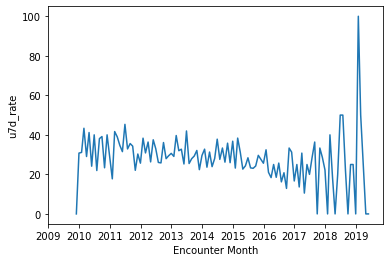

In [172]:
monthly_u7 = re_pcp.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['PCP Under 7 Days'].sum()
monthly_u7 = pd.DataFrame({'Encounter Month':monthly_u7.index, 'Under 7 Days Count':monthly_u7.values})


monthly_encounters = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Encounter ID'].count()
monthly_encounters = pd.DataFrame({'Encounter Month': monthly_encounters.index, 'Encounters Count': monthly_encounters.values})

monthly_u7_rates = pd.merge(monthly_encounters, monthly_u7, how = 'inner')

monthly_u7_rates['u7d_rate'] = 100*monthly_u7_rates['Under 7 Days Count'] / monthly_u7_rates['Encounters Count']

print(monthly_u7_rates)

g = sns.lineplot(x = 'Encounter Month', y = 'u7d_rate', data = monthly_u7_rates)
g.set(xlim = (pd.to_datetime('2008-12-31'),None))

# Problem 3
## Part A: Does 30-day readmission rate vary by hospital?

In [173]:
# For each facility NPI, calculate a sum of readmissions within 30 days
# divided by the number of admissions to that facility NPI
facility_u30_ct = readmissions.groupby('Facility Provider NPI', as_index = False)['Under 30 Days'].sum()
encounters_by_facility = readmissions.groupby('Facility Provider NPI', as_index = False)['Encounter ID'].count()

facility_u30 = pd.merge(encounters_by_facility, facility_u30_ct, how = 'left')

facility_u30['Facility U30 Days Rate'] = 100*facility_u30['Under 30 Days']/facility_u30['Encounter ID']
facility_u30
facility_u30.sort_values('Under 30 Days', ascending = False)

,Facility Provider NPI,Encounter ID,Under 30 Days,Facility U30 Days Rate
25,1184722779,1196,117,9.782609
72,14255839,889,110,12.373453
34,123315,1204,100,8.305648
124,1689772592,679,83,12.223859
148,17918545,436,50,11.467890
...,...,...,...,...
88,1484,1,0,0.000000
89,148595,1,0,0.000000
90,148767,1,0,0.000000
93,14981661,1,0,0.000000


### Note to self: Go back to beginning and make the NPI columns categories

## Part B: Does 30-day readmission rate vary by hospital physician?

In [174]:
att_u30_ct = readmissions.groupby('Attending Provider NPI', as_index = False)['Under 30 Days'].sum()
encounters_by_att = readmissions.groupby('Attending Provider NPI', as_index = False)['Encounter ID'].count()

att_u30 = pd.merge(encounters_by_att, att_u30_ct, how = 'left')

att_u30['Attending Provider U30 Days Rate'] = 100*att_u30['Under 30 Days']/att_u30['Encounter ID']
att_u30
att_u30.sort_values('Encounter ID', ascending = False)

,Attending Provider NPI,Encounter ID,Under 30 Days,Attending Provider U30 Days Rate
516,13664969,54,1,1.851852
1117,1669414744,45,2,4.444444
98,1154346583,44,2,4.545455
1546,18918758,42,6,14.285714
239,1215968474,41,2,4.878049
...,...,...,...,...
809,1497996649,1,0,0.000000
807,14979844,1,0,0.000000
804,1497944656,1,0,0.000000
801,14978752,1,0,0.000000


## Part C: Does 7-day follow-up rate vary by group PCP?

In [175]:
pcp_u7_by_group = re_pcp.groupby('Provider Group NPI', as_index = False)['PCP Under 7 Days'].sum()
encounters_by_pcp_group = re_pcp.groupby('Provider Group NPI', as_index = False)['Encounter ID'].count()

pcp_group_u7 = pd.merge(encounters_by_pcp_group, pcp_u7_by_group, how = 'left')

pcp_group_u7['PCP Group U7 Days Rate'] = 100*pcp_group_u7['PCP Under 7 Days']/pcp_group_u7['Encounter ID']
pcp_group_u7
pcp_group_u7.sort_values("PCP Under 7 Days", ascending = False)

,Provider Group NPI,Encounter ID,PCP Under 7 Days,PCP Group U7 Days Rate
357,43427248,2209,842,38.116795
40,1184722779,1164,429,36.855670
35,1164512851,481,212,44.074844
193,158787,247,77,31.174089
85,131291,173,48,27.745665
...,...,...,...,...
139,1447288345,0,0,NaN
138,1447243548,0,0,NaN
137,143731,0,0,NaN
136,1437292927,1,0,0.000000


## Part D: Does 7-day follow-up rate vary by PCP physician?

In [176]:
pcp_u7_by_provider = re_pcp.groupby('Service Provider NPI', as_index = False)['PCP Under 7 Days'].sum()
encounters_by_pcp_provider = re_pcp.groupby('Service Provider NPI', as_index = False)['Encounter ID'].count()

pcp_provider_u7 = pd.merge(encounters_by_pcp_provider, pcp_u7_by_provider, how = 'left')

pcp_provider_u7['PCP Provider U7 Days Rate'] = 100*pcp_provider_u7['PCP Under 7 Days']/pcp_provider_u7['Encounter ID']
pcp_provider_u7.sort_values("Encounter ID", ascending = False)

,Service Provider NPI,Encounter ID,PCP Under 7 Days,PCP Provider U7 Days Rate
1266,14884337,66,41,62.121212
1654,161996,52,18,34.615385
1178,14676430,50,28,56.000000
2775,19724856,50,12,24.000000
605,1285645648,49,18,36.734694
...,...,...,...,...
1217,1477847531,0,0,NaN
1219,1477948479,0,0,NaN
1220,14839778,0,0,NaN
1221,14841212,0,0,NaN


## Bonus: Readmissions Data Analyzed by Members

In [177]:
#df merge: members and readmissions
remembpcp = pd.merge(re_pcp, memb, how = 'left', on = 'Patient ID')
remembpcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,...,Hospital to PCP Days,PCP Under 7 Days,Primary Plan ID,Patient Age Integer,Patient Date of Birth,Patient ZIP Code 5-Digit,Empirically Attributed PCP Individual Provider NPI,Empirically Attributed PCP Individual Provider Description,Empirically Attributed PCP Group Provider NPI,Empirically Attributed PCP Group Provider Description
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,14171523,168389,2013-01-12,2013-01-14,NaN,NaN,O70.0,First degree perineal laceration during delivery,...,398 days,False,DS1|5047X,1,2012-11-09,94123.0,1225216351,"CLIMACO, ANNE MAE B.",43427248,UCLA MEDICAL GROUP
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,123315,2014-01-05,2014-01-12,348.4,Compression of brain,NaN,NaN,...,0 days,True,DS1|5047Y,34,1979-12-28,90307.0,1619199791,"CANALE, STEPHANIE .",43427248,UCLA MEDICAL GROUP
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,178511,123315,2012-06-13,2012-06-21,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,...,6 days,True,DS1|5047X,64,1946-01-07,92122.0,NaN,NaN,NaN,NaN
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1087,14255839,2012-12-06,2012-12-09,NaN,NaN,O70.1,Second degree perineal laceration during delivery,...,3 days,True,DS1|5047W,11,2003-01-25,90278.0,111848,"KO, ELIZABETH .",43427248,UCLA MEDICAL GROUP
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,151458,1992818256,2015-03-11,2015-03-14,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",...,235 days,False,DS1|5047W,1,2012-08-12,94118.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,17043417,1689772592,2015-02-06,2015-02-11,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",...,4 days,True,DS1|5047X,39,1979-10-19,94404.0,NaN,NaN,NaN,NaN
6210,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,14255839,2014-08-07,2014-08-10,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,...,1 days,True,DS1|5047W,33,1981-03-01,94116.0,NaN,NaN,NaN,NaN
6211,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,168981,2015-11-21,2015-11-23,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,...,12 days,False,DS1|5047W,37,1976-04-07,92126.0,1669552832,"NGUYEN, LAN T.",15884392,UCI DEPARTMENT OF MEDICINE
6212,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,17544516,168981,2015-11-24,2015-11-27,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",...,8 days,False,DS1|5047W,37,1976-04-07,92126.0,1669552832,"NGUYEN, LAN T.",15884392,UCI DEPARTMENT OF MEDICINE


# Addenda: NOTHING AFTER THIS IS FOR PROJECT USE

## Problem 1: Method 2: for-loop over iterrows()

In [178]:
days_till_readmission = []
for index, row in adm.iterrows():
    if row['Patient Adm Count'] == 1:
        readm_time = pd.to_datetime(None)
    else:
        readm_time = (row['Encounter Start Date'] - adm[(adm['Patient ID'] == row['Patient ID'])
                                &
                                (adm['Patient Adm Count'] == row['Patient Adm Count']-1)]['Encounter End Date']).dt.days.values[0]
    days_till_readmission.append(readm_time)
    
days_till_readmission    
# admissions['days_till_readmission'] = days_till_readmission
# admissions['days_till_readmission'] = admissions['days_till_readmission'].dt.days
# print(admissions['days_till_readmission'])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 135,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 496,
 47,
 None,
 None,
 285,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 126,
 None,
 31,
 0,
 5,
 47,
 25,
 28,
 73,
 27,
 27,
 4,
 None,
 None,
 None,
 None,
 None,
 None,
 4,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0,
 None,
 None,
 674,
 None,
 78,
 -19,
 -2,
 17,
 None,
 None,
 None,
 None,
 151,
 19,
 222,
 0,
 None,
 None,
 116,
 95,
 105,
 None,
 None,
 None,
 111,
 125,
 None,
 None,
 None,
 0,
 None,
 None,
 None,
 None,
 301,
 None,
 None,
 None,
 47,
 None,
 None,
 None,
 None,
 139,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 590,
 None,
 None,
 None,
 364,
 1,
 None,
 70,
 157,
 38,
 47,
 6,
 None,
 647,
 None,
 None,
 None,
 None,
 None,
 None,
 10,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 No

## Checking My Work

In [179]:
#Checking for number of encounters picked up by each aggregation in Problem 3 (Note difference from 6213)
print(facility_u30['Encounter ID'].sum())
print(att_u30['Encounter ID'].sum())
print(pcp_group_u7['Encounter ID'].sum())
print(pcp_provider_u7['Encounter ID'].sum())

6213
5884
4840
4926
